In [8]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy
# Load the dataset into a pandas dataframe.
df_mom = pd.read_csv("/content/drive/MyDrive/iss/NLP/perfectmom/data/dialog_mom", header=0, names=['index','mom_sentence','sentiment','sentiment_score'])
df_son = pd.read_csv("/content/drive/MyDrive/iss/NLP/perfectmom/data/dialog_son", header=0, names=['index','son_sentence','sentiment','sentiment_score'])

# Display the first 10 rows from the data.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df_mom.head(10)

,index,mom_sentence,sentiment,sentiment_score
0,0,烟台海边\n,pos,0.605641
1,1,见客户 然后溜达溜达\n,neg,0.111617
2,2,怎么样了？ 和陈卓同学？\n,pos,0.955282
3,3,联系了吗？\n,neg,0.300000
4,4,噢\n,pos,0.729795
5,5,等着我去了再说\n,neg,0.087975
6,6,不急\n,neg,0.107333
7,7,怎么样，？\n,neg,0.278417
8,8,我回厂了！腿都软了 把一副好牌打得稀烂是一种什么样的情形？李节~富林泛泰聚氨酯砂浆 (201...,neg,0.010619
9,9,冲突管理 包容是一生需要做的事情 俺就放心啦！ 群聊的聊天记录 << 群聊的聊天记录 曹...,pos,1.000000


In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import os
import re

# Global variables and Hyperparameters
num_words = 10000
oov_token = '<UNK>'
english_vocab_size = num_words + 1
hindi_vocab_size = num_words + 1
MAX_WORDS_IN_A_SENTENCE = 16
test_ratio = 0.2
BATCH_SIZE = 512
embedding_dim = 64
hidden_units = 1024
learning_rate = 0.006
epochs = 20

english_sentences =df_son["son_sentence"]
hindi_sentences  = df_mom["mom_sentence"]
def preprocess_sentence(sen, is_english):
	if (type(sen) != str):
		return ''
	sen = sen.strip('.')
	
	# insert space between words and punctuations
	sen = re.sub(r"([?.!,¿;।])", r" \1 ", sen)
	sen = re.sub(r'[" "]+', " ", sen)
	
	# For english, replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
	if(is_english == True):
		sen = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sen)
		sen = sen.lower()
	
	sen = sen.strip()
	sen = 'sentencestart ' + sen + ' sentenceend'
	
	sen = ' '.join(sen.split())
	return sen

In [10]:
# Loop through each datapoint having english and hindi sentence
processed_e_sentences = []
processed_h_sentences = []
for (e_sen, h_sen) in zip(english_sentences, hindi_sentences):
	processed_e_sen = preprocess_sentence(e_sen, True)
	processed_h_sen = preprocess_sentence(h_sen, False)
	if(processed_e_sen == '' or processed_h_sen == '' or processed_e_sen.count(' ') >  (MAX_WORDS_IN_A_SENTENCE-1) or processed_h_sen.count(' ') > (MAX_WORDS_IN_A_SENTENCE-1)):
		continue
	
	processed_e_sentences.append(processed_e_sen)
	processed_h_sentences.append(processed_h_sen)

print("Sentence examples: ")
print(processed_e_sentences[0])
print(processed_h_sentences[0])
print("Length of English processed sentences: " + str(len(processed_e_sentences)))
print("Length of Hindi processed sentences: " + str(len(processed_h_sentences)))

def tokenize_sentences(processed_sentences, num_words, oov_token):
	tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
	tokenizer.fit_on_texts(processed_sentences)
	word_index = tokenizer.word_index
	sequences = tokenizer.texts_to_sequences(processed_sentences)
	sequences = pad_sequences(sequences, padding = 'post')
	return word_index, sequences, tokenizer

english_word_index, english_sequences, english_tokenizer = tokenize_sentences(processed_e_sentences, num_words, oov_token)
hindi_word_index, hindi_sequences, hindi_tokenizer = tokenize_sentences(processed_h_sentences, num_words, oov_token)

# split into traning and validation set
english_train_sequences, english_val_sequences, hindi_train_sequences, hindi_val_sequences = train_test_split(english_sequences, hindi_sequences, test_size = test_ratio)
BUFFER_SIZE = len(english_train_sequences)

# Batching the training set
dataset = tf.data.Dataset.from_tensor_slices((english_train_sequences, hindi_train_sequences)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
print("No. of batches: " + str(len(list(dataset.as_numpy_iterator()))))

Sentence examples: 
sentencestart sentenceend
sentencestart 烟台海边 sentenceend
Length of English processed sentences: 3218
Length of Hindi processed sentences: 3218
No. of batches: 5


In [11]:
class Encoder(tf.keras.Model):
	
	def __init__(self, english_vocab_size, embedding_dim, hidden_units):
		super(Encoder, self).__init__()
		self.embedding = tf.keras.layers.Embedding(english_vocab_size, embedding_dim)
		self.gru = tf.keras.layers.GRU(hidden_units, return_sequences = True, return_state = True)
		
	def call(self, input_sequence):
		x = self.embedding(input_sequence)
		encoder_sequence_output, final_encoder_state = self.gru(x)
		#	Dimensions of encoder_sequence_output => (BATCH_SIZE, MAX_WORDS_IN_A_SENTENCE, hidden_units)
		#	Dimensions of final_encoder_state => (BATCH_SIZE, hidden_units)
		return encoder_sequence_output, final_encoder_state

# initialize our encoder
encoder = Encoder(english_vocab_size, embedding_dim, hidden_units)

class BasicDotProductAttention(tf.keras.layers.Layer):
	def __init__(self):
		super(BasicDotProductAttention, self).__init__()
		
	def call(self, decoder_hidden_state, encoder_outputs):
		#	Dimensions of decoder_hidden_state => (BATCH_SIZE, hidden_units)
		#	Dimensions of encoder_outputs => (BATCH_SIZE, MAX_WORDS_IN_A_SENTENCE, hidden_units)

		decoder_hidden_state_with_time_axis = tf.expand_dims(decoder_hidden_state, 2)
		#	Dimensions of decoder_hidden_state_with_time_axis => (BATCH_SIZE, hidden_units, 1)
		attention_scores = tf.matmul(encoder_outputs, decoder_hidden_state_with_time_axis)
		#	Dimensions of attention_scores => (BATCH_SIZE, MAX_WORDS_IN_A_SENTENCE, 1)
		attention_scores = tf.nn.softmax(attention_scores, axis = 1)
		weighted_sum_of_encoder_outputs = tf.reduce_sum(encoder_outputs * attention_scores, axis = 1)
		#	Dimensions of weighted_sum_of_encoder_outputs => (BATCH_SIZE, hidden_units)

		return weighted_sum_of_encoder_outputs, attention_scores

class Decoder(tf.keras.Model):
	def __init__(self, hindi_vocab_size, embedding_dim, hidden_units):
		super(Decoder, self).__init__()
		self.embedding = tf.keras.layers.Embedding(hindi_vocab_size, embedding_dim)
		self.gru = tf.keras.layers.GRU(hidden_units, return_state = True)
		self.word_probability_layer = tf.keras.layers.Dense(hindi_vocab_size, activation = 'softmax')
		self.attention_layer = BasicDotProductAttention()
		
	def call(self, decoder_input, decoder_hidden, encoder_sequence_output):
		
		x = self.embedding(decoder_input)
		#	Dimensions of x => (BATCH_SIZE, embedding_dim)
		weighted_sum_of_encoder_outputs, attention_scores = self.attention_layer(decoder_hidden, encoder_sequence_output)
		#	Dimensions of weighted_sum_of_encoder_outputs => (BATCH_SIZE, hidden_units)
		x = tf.concat([weighted_sum_of_encoder_outputs, x], axis = -1)
		x = tf.expand_dims(x, 1)
		#	Dimensions of x => (BATCH_SIZE, 1, hidden_units + embedding_dim)
		decoder_output, decoder_state = self.gru(x)
		#	Dimensions of decoder_output => (BATCH_SIZE, hidden_units)
		word_probability = self.word_probability_layer(decoder_output)
		#	Dimensions of word_probability => (BATCH_SIZE, hindi_vocab_size)
		return word_probability, decoder_state, attention_scores

# initialize our decoder
decoder = Decoder(hindi_vocab_size, embedding_dim, hidden_units)

Epoch No.: 0 Time: 6.281475305557251
Epoch No.: 1 Time: 2.0309865474700928
Epoch No.: 2 Time: 1.950629472732544
Epoch No.: 3 Time: 1.9237539768218994
Epoch No.: 4 Time: 1.8919055461883545
Epoch No.: 5 Time: 1.9497616291046143
Epoch No.: 6 Time: 1.768148422241211
Epoch No.: 7 Time: 1.9914600849151611
Epoch No.: 8 Time: 2.018857717514038
Epoch No.: 9 Time: 1.984483003616333
Epoch No.: 10 Time: 1.917849063873291
Epoch No.: 11 Time: 1.9362306594848633
Epoch No.: 12 Time: 2.016202688217163
Epoch No.: 13 Time: 1.9575676918029785
Epoch No.: 14 Time: 1.957810401916504
Epoch No.: 15 Time: 2.0378541946411133
Epoch No.: 16 Time: 1.9662272930145264
Epoch No.: 17 Time: 1.9713945388793945
Epoch No.: 18 Time: 1.9637327194213867
Epoch No.: 19 Time: 2.026843309402466
All Epoch Losses: [29.11571159362793, 35.293535232543945, 32.030856704711915, 24.87051315307617, 25.07075080871582, 21.181359481811523, 19.868018341064452, 19.67982711791992, 19.232657623291015, 18.823327255249023, 18.405620574951172, 17.9

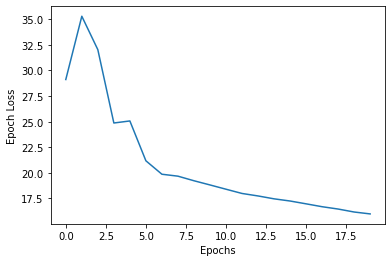

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
def loss_function(actual_words, predicted_words_probability):
	loss = loss_object(actual_words, predicted_words_probability)
	mask = tf.where(actual_words > 0, 1.0, 0.0)
	return tf.reduce_mean(mask * loss)

def train_step(english_sequences, hindi_sequences):
	loss = 0
	with tf.GradientTape() as tape:
		encoder_sequence_output, encoder_hidden = encoder(english_sequences)
		decoder_hidden = encoder_hidden
		decoder_input = hindi_sequences[:, 0]
		for i in range(1, hindi_sequences.shape[1]):
			predicted_words_probability, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_sequence_output)
			actual_words = hindi_sequences[:, i]
			# if all the sentences in batch are completed
			if np.count_nonzero(actual_words) == 0:
				break
			loss += loss_function(actual_words, predicted_words_probability)

			decoder_input = actual_words

	variables = encoder.trainable_variables + decoder.trainable_variables
	gradients = tape.gradient(loss, variables)
	optimizer.apply_gradients(zip(gradients, variables))
	return loss.numpy()

all_epoch_losses = []
training_start_time = time.time()
for epoch in range(epochs):
	epoch_loss = []
	start_time = time.time()
	for(batch, (english_sequences, hindi_sequences)) in enumerate(dataset):
		batch_loss = train_step(english_sequences, hindi_sequences)
		epoch_loss.append(batch_loss)

	all_epoch_losses.append(sum(epoch_loss)/len(epoch_loss))
	print("Epoch No.: " + str(epoch) + " Time: " + str(time.time()-start_time))

print("All Epoch Losses: " + str(all_epoch_losses))
print("Total time in training: " + str(time.time() - training_start_time))

plt.plot(all_epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Epoch Loss")
plt.show()

In [17]:
def get_sentence_from_sequences(sequences, tokenizer):
	return tokenizer.sequences_to_texts(sequences)

# Testing
def translate_sentence(sentence):
	sentence = preprocess_sentence(sentence, True)
	sequence = english_tokenizer.texts_to_sequences([sentence])[0]
	sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen = MAX_WORDS_IN_A_SENTENCE, padding = 'post')
	encoder_input = tf.convert_to_tensor(sequence)
	encoder_sequence_output, encoder_hidden = encoder(encoder_input)
	decoder_input = tf.convert_to_tensor([hindi_word_index['sentencestart']])
	decoder_hidden = encoder_hidden
	
	sentence_end_word_id = hindi_word_index['sentenceend']
	hindi_sequence = []
	for i in range(MAX_WORDS_IN_A_SENTENCE*2):
		predicted_words_probability, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_sequence_output)
		# taking the word with maximum probability
		predicted_word_id = tf.argmax(predicted_words_probability[0]).numpy()
		hindi_sequence.append(predicted_word_id)
		# if the word 'sentenceend' is predicted, exit the loop
		if predicted_word_id == sentence_end_word_id:
			break
		decoder_input = tf.convert_to_tensor([predicted_word_id])
	print(sentence)
	return get_sentence_from_sequences([hindi_sequence], hindi_tokenizer)



In [26]:
son_say="身体怎么样"
print('Son:   ', son_say)
print("Mom:   ", translate_sentence(son_say))

Son:    身体怎么样
sentencestart sentenceend
Mom:    ['噢 sentenceend']
